<a href="https://colab.research.google.com/github/gmagannaDevelop/segnet/blob/mru_tests/TruthTest_MultiResUNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MultiResUNet
## DCI-Net
#### Gustavo Magaña López

Reimplementación de los experimentos originales.

\########################################################

In [24]:
!ls

drive  sample_data


In [25]:
!apt install jq

Reading package lists... Done
Building dependency tree       
Reading state information... Done
jq is already the newest version (1.5+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.


In [26]:
## If changes are made to the repo, uninstall and
## a fresh pip install are required, so it seems.
#!pip uninstall segnet
!pip install git+https://github.com/gmagannaDevelop/segnet.git@mru_tests
##!pip install git+https://github.com/gmagannaDevelop/segnet.git@log_hotfix

  Cloning https://github.com/gmagannaDevelop/segnet.git (to revision mru_tests) to /tmp/pip-req-build-3pwz5v2p
  Running command git clone -q https://github.com/gmagannaDevelop/segnet.git /tmp/pip-req-build-3pwz5v2p
  Running command git checkout -b mru_tests --track origin/mru_tests
  Switched to a new branch 'mru_tests'
  Branch 'mru_tests' set up to track remote branch 'mru_tests' from 'origin'.
  Created wheel for segnet: filename=segnet-0.4-cp36-none-any.whl size=25585 sha256=090e4e5955c4cd7e1d8e6ee63906fcf4dc3837f1d4eda03c4acbff97adb19ebf
  Stored in directory: /tmp/pip-ephem-wheel-cache-lr_at52a/wheels/f1/c1/51/0ee27f445c3a618413714a84d4f5500547456389437a85a87f
Successfully built segnet


Imports

In [27]:
### System-related
import sys
import os
import datetime 
from typing import Optional, List, Tuple, Any, NoReturn, Callable, Union
#import importlib.util
###############################################################

### Machine learning specific
#import segmentation_models as sm
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import keras.models
import tensorflow as tf
###############################################################

### In-Out
from skimage import io as skio
import glob
###############################################################

### Visualization
import seaborn as sns
###############################################################

### Numerical
import numpy as np
###############################################################

### Repo-specific (segnet)
from segnet.train import train_segnet
from segnet.models import multiresunet as mru
from segnet.models import multiresunet2 as mru2
from segnet.models import multiresunet3 as mru3
from segnet.utils import timing
from segnet.metrics import metrics as mts
#from segnet.segnet.train.train_segnet import train_segnet
#import segnet.segnet as segnet

### Data-related
from google.colab import drive, files
drive.mount('/content/drive/')
###############################################################


### Not an import, but mandatory to be defined here :
root_dir   = "drive/My Drive/DCI-Net"
_log_file  = os.path.join(root_dir, "time_logs.jsonl")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Function definition

In [0]:
def yield_model_name(
    architecture: str = "MultiResUNet",
    _name: Optional[str] = None,
    date: Optional[str] = None
) -> str:
  """
    Yield a model name, to be passed to other functions.
    Said model name consisting of an architecture name, 
    the (UTCtime)
  """
  if date is None:
    date = str(datetime.datetime.utcnow()).split(".")[0]
  if _name is not None:
    return f"{architecture}-({_name})-({date}).h5"

  return f"{architecture}-({date}).h5"

def yield_mask_directory(
    architecture: str = "MultiResUNet",
    date: Optional[str] = None
) -> str:
  """
    Yield a model name, to be passed to other functions.
    Said model name consisting of an architecture name, 
    the (UTCtime)
  """
  if date is None:
    date = str(datetime.datetime.utcnow()).split(".")[0]
    #date = str(datetime.datetime.utcnow()).split(".")[0].split(" ")[0]
  return f"{architecture}-({date})"

In [29]:
yield_model_name(_name='test')

'MultiResUNet-(test)-(2020-01-13 18:56:37).h5'

In [30]:
yield_mask_directory()

'MultiResUNet-(2020-01-13 18:56:39)'

In [31]:
!ls "drive/My Drive/DCI-Net/Masks"

Sunday3nov


Instead of commenting out the different paths, I should create a dictionary containing the names of the datasets and their respective paths.

In [0]:
dataset_paths = {
    "colonoscopy": "drive/My Drive/DCI-Net/Colab_data/colonoscopy",    # Full original
    "colonoscopy80": "drive/My Drive/DCI-Net/Colab_data/dermoscopy80", # reduced to 80 images
    "chinese1": "drive/My Drive/DCI-Net/Colab_data/Dataset 2"          # Chinese dataset, Abdiel's
}

In [0]:
# Declare the paths to use (following the Keras convention)
# https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Model#fit_generator

masks_path = img_path = data_path  = dataset_paths["colonoscopy80"]

_img_path   = os.path.join(data_path, 'imgs')
_masks_path = os.path.join(data_path, 'msks')

_model_snapshots_dir = os.path.join(root_dir, "ModelSnapshots")
_model_log_path = os.path.join(
    _model_snapshots_dir, 
    yield_model_name(architecture="MultiResUNet")
)


In [34]:
_model_authors = list(
    map(
        lambda x: os.path.join(_model_snapshots_dir, yield_model_name(_name=x)), ['Edwin', 'Gustavo', 'Original'] 
        )
    )
_model_authors

['drive/My Drive/DCI-Net/ModelSnapshots/MultiResUNet-(Edwin)-(2020-01-13 18:56:54).h5',
 'drive/My Drive/DCI-Net/ModelSnapshots/MultiResUNet-(Gustavo)-(2020-01-13 18:56:54).h5',
 'drive/My Drive/DCI-Net/ModelSnapshots/MultiResUNet-(Original)-(2020-01-13 18:56:54).h5']

In [35]:
print(f"{data_path}\n {masks_path}\n {img_path}\n {_img_path}\n {_masks_path}\n {_model_log_path}")

drive/My Drive/DCI-Net/Colab_data/dermoscopy80
 drive/My Drive/DCI-Net/Colab_data/dermoscopy80
 drive/My Drive/DCI-Net/Colab_data/dermoscopy80
 drive/My Drive/DCI-Net/Colab_data/dermoscopy80/imgs
 drive/My Drive/DCI-Net/Colab_data/dermoscopy80/msks
 drive/My Drive/DCI-Net/ModelSnapshots/MultiResUNet-(2020-01-13 18:56:50).h5


Define hyperparameters


In [0]:
__comments = (lambda x: [
              f"Edwin's implementation : models/multiresunet.py, {x}",
              f"Gustavo's implementation : models/multiresunet2.py, {x}",
              f"Original implementation : models/multiresunet3.py, {x}", 
])("")

hyper_params = dict(
    batch_size = 4,
    epochs = 40,
    steps_per_epoch=5
    #model_file = _model_log_path
)

# DEBUG COMMENT OUT WHEN TRAINING : 
_debug_hyper_params = dict(
    batch_size = 8,
    epochs = 1,
    steps_per_epoch=2,
    model_file = _model_log_path
)

Get the stored snapshots :

In [37]:
snapshots = os.listdir(_model_snapshots_dir)
snapshots

['MultiResUNet-(2019-10-29 03:29:04).h5',
 'MultiResUNet-(2019-11-04 01:48:44).h5',
 'MultiResUNet-(2019-11-04 03:14:17).h5',
 'MultiResUNet-(2019-11-04 03:30:53).h5',
 'MultiResUNet-(2019-11-04 19:16:27).h5',
 'MultiResUNet-(Edwin)-(2019-11-04 21:36:35).h5',
 'MultiResUNet-(Gustavo)-(2019-11-04 21:36:35).h5',
 'MultiResUNet-(Original)-(2019-11-04 21:36:35).h5',
 'MultiResUNet-(Edwin)-(2020-01-11 23:55:36).h5',
 'MultiResUNet-(Gustavo)-(2020-01-11 23:55:36).h5',
 'MultiResUNet-(Original)-(2020-01-11 23:55:36).h5',
 'MultiResUNet-(2020-01-11 23:41:29).h5',
 'MultiResUNet-(Edwin)-(2020-01-12 02:46:40).h5',
 'MultiResUNet-(Gustavo)-(2020-01-12 02:46:40).h5',
 'MultiResUNet-(Original)-(2020-01-12 02:46:40).h5']

Choose a snapshot to load, if so desired :

In [38]:
load_snapshot = os.path.join(_model_snapshots_dir, snapshots[-1])
load_snapshot

'drive/My Drive/DCI-Net/ModelSnapshots/MultiResUNet-(Original)-(2020-01-12 02:46:40).h5'


Instantiate a MultiResUNet model, **optionally** from a checkpoint :

In [39]:
models = [
  mru.MultiResUnet(),
  mru2.MultiResUNet(),
  mru3.MultiResUnet()
]
    
# TOGGLE THIS !
from_checkpoint = False

if from_checkpoint:
  # model1.load_weights(load_snapshot)
  # model2.load_weights(load_snapshot)
  pass

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [20]:
# Dropping this as it relies on segmed's API.
""""
trainer = lambda x, y, z: train_segnet.train_segnet(
    x,
    _img_path,
    _masks_path,
    **hyper_params,
    model_file=y,
    _comment=z
)
"""
# historiae = list(map(trainer, models, _model_authors, __comments))

'"\ntrainer = lambda x, y, z: train_segnet.train_segnet(\n    x,\n    _img_path,\n    _masks_path,\n    **hyper_params,\n    model_file=y,\n    _comment=z\n)\n'

In [0]:
#collection = skio.ImageCollection(_img_path)
#unaimagen  = skio.imread(os.path.join(_img_path, ))

In [0]:
def new_train(
    model,
    img_path,
    mask_path,
    batch_size=16,
    epochs=25,
    steps_per_epoch=3125,
    val_split=0.2,
    optimizer=tf.keras.optimizers.Adam(),
    monitor="val_jaccard_index",
    model_file="unet_simple.h5",
    seed=1,
    show=False,
):

    """
    Takes two paths for images and segmentation maps and rescales them, splits
    them into training and validation, while saving the best model trained.
    The paths must comply to the Keras API convention as specified in their
    documentation.

    Args:
        batch_size (int): Size of the batch to be processed.
        epochs (int): Number of epochs to train the model.
        steps_per_epoch (int): Total number of steps (batches of samples) to yield 
            before declaring one epoch finished and starting the next epoch.
        val_split (float): Value between 0.0 and 1.0 representing the size in percentage
            to split the dataset.
        optimizer (`Optimizer`): A Keras optimizer instance with a valid syntax from TensorFlow.
        monitor (str): Quantity to monitor during training; follow the Keras convention.
        model_file (str): File to create for the ModelCheckpoint callback from Keras.
        seed (int): Value to seed the ImageDataGenerator and always retrieve the same batch
            of pairs of images.
        show (bool): If true, plots a pair of size `batch_size` to see if the image and its
            segmentation maps are consistent. For debugging purposes only.
    """

    # Rescale and convert to float32 both subsets
    data_gen_args = {
        "rescale": 1.0 / 255.0,
        "validation_split": val_split,
        "dtype": tf.float32,
    }

    # Crea the training generators with the defined transformations
    image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)
    mask_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)
    
    # Take images from directories
    image_generator_train = image_datagen.flow_from_directory(
        img_path,
        class_mode=None,
        color_mode="rgb",
        batch_size=batch_size,
        seed=seed,
        subset="training",
    )
    mask_generator_train = mask_datagen.flow_from_directory(
        mask_path,
        class_mode=None,
        color_mode="grayscale",
        batch_size=batch_size,
        seed=seed,
        subset="training",
    )
    # Combine both generators
    # This need to be a generator of generators, see the following
    # https://github.com/tensorflow/tensorflow/issues/32357
    train_generator = (
        pair for pair in zip(image_generator_train, mask_generator_train)
    )

    # And now the validation generators
    image_generator_val = image_datagen.flow_from_directory(
        img_path,
        class_mode=None,
        color_mode="rgb",
        batch_size=batch_size,
        seed=seed,
        subset="validation",
    )

    mask_generator_val = mask_datagen.flow_from_directory(
        mask_path,
        class_mode=None,
        color_mode="grayscale",
        batch_size=batch_size,
        seed=seed,
        subset="validation",
    )

    # Combine both generators, with same issue as before
    val_generator = (pair for pair in zip(image_generator_val, mask_generator_val))

    # DEBUGGING ONLY, for checking that both image and maps are batched together
    if show:
        import matplotlib.pyplot as plt

        for i, j in train_generator:
            plt.figure(0)
            plt.imshow(i[0, ...])
            plt.figure(1)
            plt.imshow(j[0, ..., 0])
            plt.show()

    # Define the checkpoint callback, always maximum mode for custom metrics
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        model_file, monitor=monitor, verbose=1, save_best_only=True, mode="max"
    )

    # Compile the model with an and custom metrics
    model.compile(
        loss=tf.keras.losses.binary_crossentropy,
        optimizer=optimizer,
        metrics=[mts.jaccard_index, mts.dice_coef],
    )

    # Create history of model and return it
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        callbacks=[checkpoint],
        verbose=1,
        validation_data=val_generator,
        validation_steps=steps_per_epoch,
    )

    return history

In [0]:
trainer = lambda x, y, z: new_train(
    x,
    _img_path,
    _masks_path,
    **hyper_params,
    model_file=y,
    show=True,
    _comment=z
)

Train the model :

In [22]:
__comments

["Edwin's implementation : models/multiresunet.py, ",
 "Gustavo's implementation : models/multiresunet2.py, ",
 'Original implementation : models/multiresunet3.py, ']

In [23]:
historiae = list(map(trainer, models[-1], _model_authors[-1], __comments[-1]))

NameError: ignored

In [0]:
"""
history = train_segnet.train_segnet(
    models[2],
    _img_path,
    _masks_path,
    **hyper_params,
    _comment=__comments[2]
)
"""


'\nhistory = train_segnet.train_segnet(\n    models[2],\n    _img_path,\n    _masks_path,\n    **hyper_params,\n    _comment=__comments[2]\n)\n'

In [0]:
print(_masks_path)

drive/My Drive/DCI-Net/Colab_data/dermoscopy80/msks


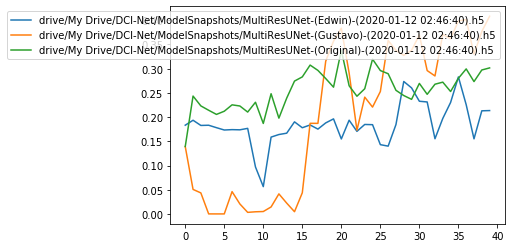

In [0]:
_jaccards = list(map(lambda x: x.history['val_jaccard_index'], historiae))
for _jaccard, _author in zip(_jaccards, _model_authors):
  sns.lineplot(list(range(len(_jaccard))), _jaccard, label=_author)

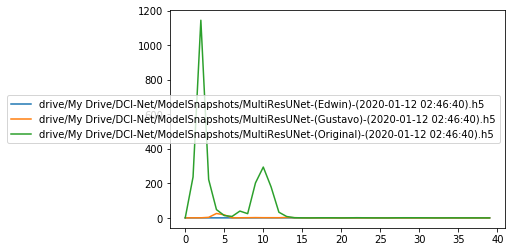

In [0]:
_losses = list(map(lambda x: x.history['val_loss'], historiae))
for _loss, _author in zip(_losses, _model_authors):
  sns.lineplot(list(range(len(_loss))), _loss, label=_author)

In [0]:
!cat "drive/My Drive/DCI-Net/time_logs.jsonl" | jq

/bin/bash: jq: command not found
cat: 'drive/My Drive/DCI-Net/time_logs.jsonl': No such file or directory


In [0]:
# 1 validación 5 pliegues
def 

In [0]:
@timing.time_log(path_to_logfile=_log_file)
def _dummy_debug_function(*args, **kw):
  pass
  

In [0]:
log

NameError: ignored

In [0]:
_dummy_debug_function(5, '234', 5.2, hola='pass', foo='bar')